In [1]:
import boto3
import os
from dotenv import load_dotenv

load_dotenv()
access_key_id = os.getenv("ACCESS_KEY_ID")
secret_access_key = os.getenv("SECRET_ACCESS_KEY")
minio_url = "http://" + os.getenv("S3_API_ENDPOINT")


minio_client = boto3.client(
    "s3",
    aws_access_key_id=access_key_id,
    aws_secret_access_key=secret_access_key,
    endpoint_url=minio_url
)

new_bucket = "exploitation-zone-task2-images-text"
try:
    minio_client.create_bucket(Bucket=new_bucket)
except (minio_client.exceptions.BucketAlreadyExists, minio_client.exceptions.BucketAlreadyOwnedByYou):
    print(f"Bucket '{new_bucket}' already exists")

In [ ]:
from PIL import Image
import os
import io
import chromadb
from chromadb.utils.data_loaders import ImageLoader
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction

client = chromadb.HttpClient(host="localhost", port=8000)
paginator = minio_client.get_paginator('list_objects_v2')
exploitation_zone = "exploitation-zone-task2-images-text"
trusted_zone = "trusted-zone"
name_collection1 = "multimodal_collection_images"
name_collection2 = "multimodal_collection_text"
name_collection3 = "multimodal_collection_audios"

embedding_function = OpenCLIPEmbeddingFunction()
data_loader = ImageLoader()

try:
    client.delete_collection(name=name_collection1)
except Exception:
    pass

try:
    imatges_col = client.get_or_create_collection(
        name=name_collection1,
        embedding_function=embedding_function,
        data_loader=data_loader
    )
except Exception as e:
    print(f"Error accessing or creating collection: {e}")
    exit(1)

# FOR THE IMAGES NOW.
for page in paginator.paginate(Bucket=trusted_zone, Prefix="images/"):
    for obj in page.get("Contents", []):
        key = obj.get("Key", "")
        response = minio_client.get_object(Bucket=trusted_zone, Key=key)
        image_data = response['Body'].read()
        image = Image.open(io.BytesIO(image_data)).convert('RGB')

        temp_path = f"/tmp/{os.path.basename(key)}"
        with open(temp_path, "wb") as f:
            f.write(image_data)

        imatges_col.add(
            ids=[key],
            uris=[temp_path],
            metadatas=[{"bucket": trusted_zone, "key": key, "type": "image"}]
        )

        minio_client.copy_object(
            Bucket=exploitation_zone,
            CopySource={'Bucket': trusted_zone, 'Key': key},
            Key=key
        )
        
        
try:
    client.delete_collection(name=name_collection2)
except Exception:
    pass

try:
    text_col = client.get_or_create_collection(
        name=name_collection2,
        embedding_function=embedding_function,
    )
except Exception as e:
    print(f"Error accessing or creating collection: {e}")
    exit(1)
        
# FOR THE TEXT NOW.
for page in paginator.paginate(Bucket=trusted_zone, Prefix="text/"):
    for obj in page.get("Contents", []):
        key = obj.get("Key", "")
        response = minio_client.get_object(Bucket=trusted_zone, Key=key)
        document_content = response['Body'].read().decode('utf-8')
        
        text_col.add(
            ids=[key],
            documents=[document_content],
            metadatas=[{"bucket": trusted_zone, "key": key, "type": "text"}]
        )
        
        minio_client.copy_object(
            Bucket=exploitation_zone,
            CopySource={'Bucket': trusted_zone, 'Key': key},
            Key=key
        )
print("Col·lecció multimodal creada correctament!")
print("Nombre total d'elements:", len(text_col.get()["ids"]), len(imatges_col.get()["ids"]))
#print("returned keys:", list(result.keys()))

open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Col·lecció multimodal creada correctament!
Nombre total d'elements: 0 100


In [4]:
from IPython.display import display
from PIL import Image
import io

def query_multimodal(query_text, text_col, imatges_col, minio_client, top_k=3):
    """
    Donat un text, busca les imatges i textos més similars
    usant dues col·leccions sincronitzades amb CLIP.
    """

    print(f"\nQuery: '{query_text}'")
    print("=" * 90)

    emb = imatges_col._embedding_function([query_text])[0]

    res_texts = text_col.query(query_embeddings=[emb], n_results=top_k, include=["documents", "distances"])
    res_imgs  = imatges_col.query(query_embeddings=[emb], n_results=top_k, include=["metadatas", "distances"])

    # --- TEXTS similars ---
    print("\nTextos similars:")
    for i, (doc, dist) in enumerate(zip(res_texts["documents"][0], res_texts["distances"][0])):
        preview = doc.strip().replace("\n", " ")
        print(f"{i+1}. (dist={dist:.4f}) {preview[:200]}...")

    # --- IMATGES similars ---
    print("\nImatges similars:")
    for i, (meta, dist) in enumerate(zip(res_imgs["metadatas"][0], res_imgs["distances"][0])):
        bucket = meta.get("bucket")
        key = meta.get("key")
        print(f"{i+1}. (dist={dist:.4f}) {key}")

        try:
            response = minio_client.get_object(Bucket=bucket, Key=key)
            image_data = response["Body"].read()
            img = Image.open(io.BytesIO(image_data))
            display(img)
        except Exception as e:
            print(f"No s'ha pogut mostrar la imatge: {e}")



Query: 'CAT'

Textos similars:

Imatges similars:
1. (dist=0.7689) images/ISIC_0034196.png


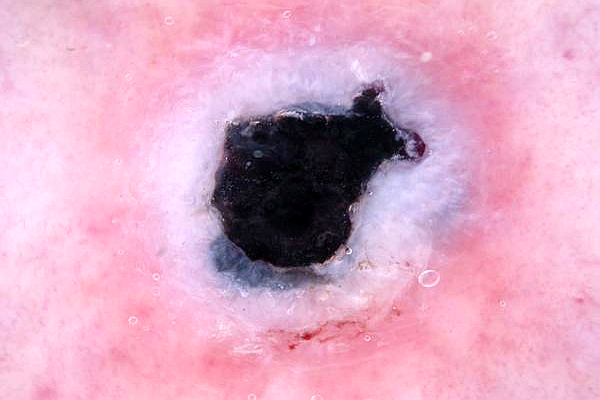

2. (dist=0.7725) images/ISIC_0025202.png


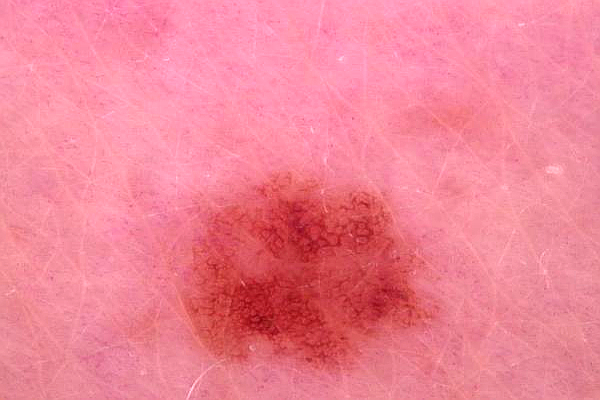

3. (dist=0.7726) images/ISIC_0030197.png


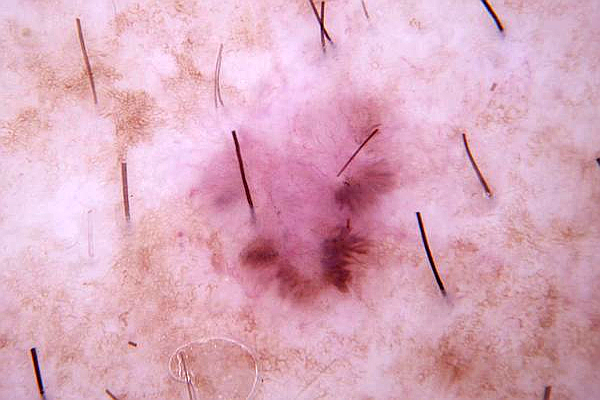

In [7]:
query_multimodal(
    query_text="CAT",
    text_col=text_col,
    imatges_col=imatges_col,
    minio_client=minio_client,
    top_k=3
)


# Multimodal query using ImageBind

In [ ]:
from imagebind import data
import torch
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType

text_list=["skin cancer"]
image_paths=["../../output/images/ISIC_0024388.jpg"]
audio_paths=["../../output/audios/answer_0.wav"]

device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Instantiate model
model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)

# Load data
inputs = {
    ModalityType.TEXT: data.load_and_transform_text(text_list, device),
    ModalityType.VISION: data.load_and_transform_vision_data(image_paths, device),
    ModalityType.AUDIO: data.load_and_transform_audio_data(audio_paths, device),
}

with torch.no_grad():
    embeddings = model(inputs)

print(
    "Vision x Text: ",
    torch.softmax(embeddings[ModalityType.VISION] @ embeddings[ModalityType.TEXT].T, dim=-1),
)
print(
    "Audio x Text: ",
    torch.softmax(embeddings[ModalityType.AUDIO] @ embeddings[ModalityType.TEXT].T, dim=-1),
)
print(
    "Vision x Audio: ",
    torch.softmax(embeddings[ModalityType.VISION] @ embeddings[ModalityType.AUDIO].T, dim=-1),
)

# Expected output:
#
# Vision x Text:
# tensor([[9.9761e-01, 2.3694e-03, 1.8612e-05],
#         [3.3836e-05, 9.9994e-01, 2.4118e-05],
#         [4.7997e-05, 1.3496e-02, 9.8646e-01]])
#
# Audio x Text:
# tensor([[1., 0., 0.],
#         [0., 1., 0.],
#         [0., 0., 1.]])
#
# Vision x Audio:
# tensor([[0.8070, 0.1088, 0.0842],
#         [0.1036, 0.7884, 0.1079],
#         [0.0018, 0.0022, 0.9960]])


/home/jowy/ImageBind/imagebind/data.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


: 